In [39]:
import pandas as pd
import numpy as np
import os
import sys
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List

# Configure pandas to display all columns
pd.set_option('display.max_columns', None)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Add project root to sys.path
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.db.nst_db_utils import *

In [40]:
goalie_stats = get_goalie_stats(
    start_date="2024-10-01",
    end_date="2025-01-15"
)

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.


In [41]:
goalie_stats

,date,player,team,toi,shots_against,saves,goals_against,sv_pct,gaa,gsaa,xg_against,hd_shots_against,hd_saves,hd_goals_against,hdsv_pct,md_shots_against,md_saves,md_goals_against,mdsv_pct,ld_shots_against,ld_saves,ld_goals_against,ldsv_pct,rush_attempts_against,rebound_attempts_against,avg_shot_distance,avg_goal_distance
0,2025-01-15,Dustin Tokarski,CAR,57.72,24,21,3,0.875,3.12,-0.62,2.3,7,6,1,0.857,6,4,2,0.667,6,6,0,1.0,4,3,54.58,27.67
1,2025-01-15,Calvin Pickard,EDM,60.0,34,31,3,0.912,3.0,0.37,2.72,6,5,1,0.833,11,10,1,0.909,16,15,1,0.938,4,5,35.0,14.67
2,2025-01-15,Filip Gustavsson,MIN,57.6,36,31,5,0.861,5.21,-1.43,2.51,7,5,2,0.714,4,4,0,1.0,24,21,3,0.875,3,1,33.81,15.4
3,2025-01-15,Ukko-Pekka Luukkonen,BUF,60.0,37,35,2,0.946,2.0,1.67,3.65,4,4,0,1.0,6,6,0,1.0,24,22,2,0.917,5,13,47.43,47.0
4,2025-01-14,Leevi Merilainen,OTT,60.0,24,24,0,1.0,0.0,2.26,1.23,2,2,0,1.0,7,7,0,1.0,15,15,0,1.0,2,4,46.21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,2024-10-08,Connor Ingram,UTA,60.0,26,24,2,0.923,2.0,1.17,3.11,8,6,2,0.75,5,5,0,1.0,13,13,0,1.0,0,6,34.46,11.5
1478,2024-10-05,Jake Allen,NJD,60.0,18,17,1,0.944,1.0,0.31,1.78,3,2,1,0.667,1,1,0,1.0,12,12,0,1.0,1,6,52.94,7.0
1479,2024-10-05,Devon Levi,BUF,56.77,37,34,3,0.919,3.17,-0.31,3.41,9,7,2,0.778,11,10,1,0.909,15,15,0,1.0,3,6,35.08,19.33
1480,2024-10-04,Jacob Markstrom,NJD,59.63,31,30,1,0.968,1.01,1.34,3.61,6,5,1,0.833,5,5,0,1.0,19,19,0,1.0,3,9,39.58,16.0


In [42]:

def prepare_rolling_features(df, window_size=10):
    """Create rolling averages and statistics for each goalie"""
    feature_columns = [
        'shots_against', 'sv_pct', 'gaa', 'gsaa',
        'xg_against', 
        'hd_shots_against', 'hdsv_pct',
        'md_shots_against', 'mdsv_pct',
        'ld_shots_against', 'ldsv_pct',
        'toi'  # Removed columns that don't exist in the data
    ]
    
    # Make a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Convert TOI to minutes if it's in HH:MM:SS format
    if df['toi'].dtype == 'object':
        df['toi'] = df['toi'].apply(lambda x: sum(int(t) * 60 ** i for i, t in enumerate(reversed(x.split(':')))))
    
    # Verify we have the required columns
    missing_cols = [col for col in feature_columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns: {missing_cols}")
        
    df = df.sort_values(['player', 'date']).reset_index(drop=True)
    
    rolling_stats = []
    for name, group in df.groupby('player'):
        # Make a copy of the group to avoid SettingWithCopyWarning
        group = group.copy()
        
        try:
            # Calculate rolling averages with exponential weighting
            for col in feature_columns:
                group[f'{col}_rolling_avg'] = group[col].ewm(
                    span=window_size, min_periods=1
                ).mean()
                
                group[f'{col}_rolling_std'] = group[col].ewm(
                    span=window_size, min_periods=1
                ).std()
            
            # Calculate advanced trend features
            group['sv_pct_trend'] = group['sv_pct'].diff()
            group['gsaa_trend'] = group['gsaa'].diff()
            group['xg_diff'] = group['goals_against'] - group['xg_against']
            group['xg_diff_rolling'] = group['xg_diff'].rolling(
                window=window_size, min_periods=1
            ).mean()
            
            # Add workload features
            group['days_rest'] = group['date'].diff().dt.days
            group['games_last_7'] = group.rolling('7D', on='date')['date'].count()
            
            rolling_stats.append(group)
            
        except Exception as e:
            print(f"Error processing player {name}: {str(e)}")
    
    if not rolling_stats:
        raise ValueError("No data was processed successfully")
        
    return pd.concat(rolling_stats)

def prepare_features(df, window_size=10):
    """Prepare features for model training or prediction"""
    rolling_df = prepare_rolling_features(df, window_size)
    
    # Create feature matrix
    feature_cols = [col for col in rolling_df.columns 
                   if any(feat in col for feat in 
                       ['rolling_avg', 'rolling_std', 'trend', 'games_last_7', 'days_rest'])]
    
    X = rolling_df[feature_cols].fillna(0)
    return X, rolling_df

def train_model(historical_data, window_size=10) -> Tuple[RandomForestRegressor, StandardScaler, dict]:
    """Train the model on historical goalie data and return evaluation metrics"""
    X, processed_data = prepare_features(historical_data, window_size)
    y = processed_data['sv_pct'].shift(-1)  # Next game's save percentage
    
    # Remove last row of each goalie (no next game to predict)
    mask = processed_data.groupby('player').tail(1).index
    X = X.drop(mask)
    y = y.drop(mask)
    
    # Remove any remaining NaN values
    mask = ~y.isna()
    X = X[mask]
    y = y[mask]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    rf_model = RandomForestRegressor(
        n_estimators=1000,
        max_depth=10,
        random_state=42
    )
    rf_model.fit(X_train_scaled, y_train)
    
    # Make predictions on test set
    y_pred = rf_model.predict(X_test_scaled)
    
    # Calculate evaluation metrics
    metrics = {
        'r2_score': r2_score(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'feature_importance': dict(zip(X.columns, rf_model.feature_importances_))
    }
    
    return rf_model, scaler, metrics

def predict_next_game(goalie_history, model, scaler, window_size=10):
    """Predict save percentage for next game"""
    X, _ = prepare_features(goalie_history, window_size)
    X_latest = X.iloc[[-1]]  # Get most recent game's features
    X_scaled = scaler.transform(X_latest)
    
    predicted_sv = model.predict(X_scaled)[0]
    return predicted_sv

def calculate_performance_scalar(predicted_sv, league_avg_sv=0.910):
    """Convert predicted save percentage to performance scalar"""
    sv_diff = predicted_sv - league_avg_sv
    return 1 - sv_diff

def prepare_game_data(df):
    """Prepare scraped game data for model input"""
    # Convert date to datetime if not already
    if df['date'].dtype != 'datetime64[ns]':
        df['date'] = pd.to_datetime(df['date'])
    
    # Ensure all numeric columns are float
    numeric_cols = [
        'toi', 'shots_against', 'saves', 'goals_against', 'sv_pct', 
        'gaa', 'gsaa', 'xg_against',  # Added xg_against
        'hd_shots_against', 'hd_saves', 'hd_goals_against', 'hdsv_pct',
        'md_shots_against', 'md_saves', 'md_goals_against', 'mdsv_pct',
        'ld_shots_against', 'ld_saves', 'ld_goals_against', 'ldsv_pct'
    ]
    
    # First convert to string to handle any Decimal objects
    for col in numeric_cols:
        df[col] = df[col].astype(str).astype(float)
    
    return df

In [43]:
# Now let's evaluate the model
processed_data = prepare_game_data(goalie_stats)
model, scaler, metrics = train_model(processed_data)

# Print evaluation metrics
print("Model Evaluation Metrics:")
print(f"R² Score: {metrics['r2_score']:.4f}")
print(f"Mean Absolute Error: {metrics['mae']:.4f}")
print(f"Root Mean Squared Error: {metrics['rmse']:.4f}")

Model Evaluation Metrics:
R² Score: -0.0933
Mean Absolute Error: 0.0519
Root Mean Squared Error: 0.0714


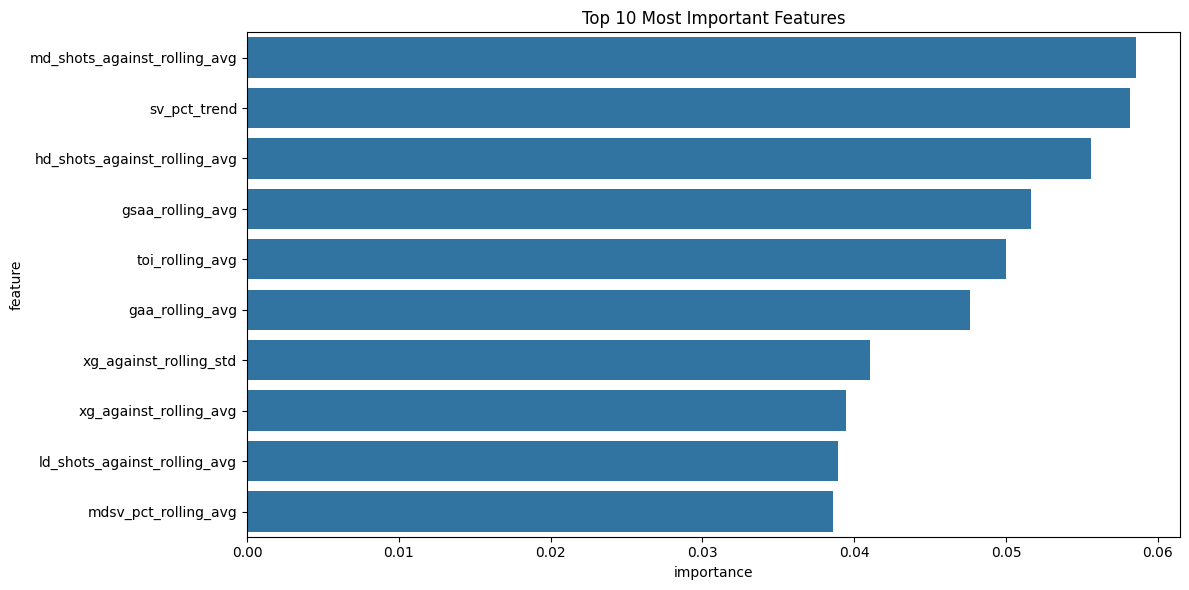

In [44]:
# Plot feature importance
plt.figure(figsize=(12, 6))
importance_df = pd.DataFrame({
    'feature': list(metrics['feature_importance'].keys()),
    'importance': list(metrics['feature_importance'].values())
}).sort_values('importance', ascending=False)

sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()

Original data length: 20
Predictions length: 20
X_scaled shape: (20, 28)


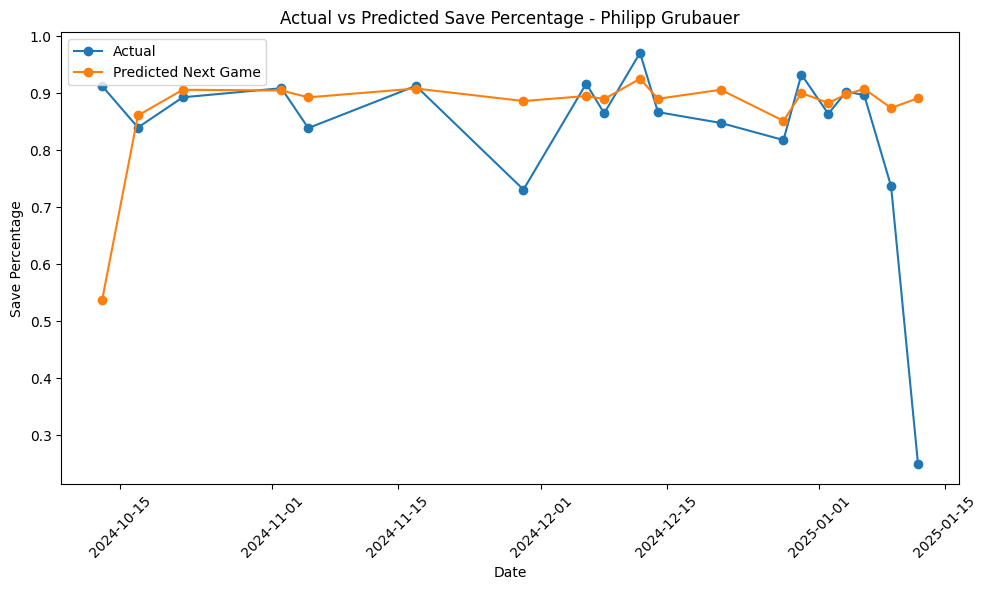


Predicted save percentage for Philipp Grubauer's next game: 0.797


In [45]:
# Plot actual vs predicted values for a specific goalie
goalie_name = 'Philipp Grubauer'
goalie_data = processed_data[processed_data['player'] == goalie_name].copy()  # Make a copy
X, processed_df = prepare_features(goalie_data)
X_scaled = scaler.transform(X)
predictions = model.predict(X_scaled)

# Print dimensions to debug
print(f"Original data length: {len(goalie_data)}")
print(f"Predictions length: {len(predictions)}")
print(f"X_scaled shape: {X_scaled.shape}")

# Create the plot with aligned data
plt.figure(figsize=(10, 6))
# Use the same date range for both actual and predicted values
dates = goalie_data['date'].iloc[:-1]  # Remove last date
actual_values = goalie_data['sv_pct'].iloc[:-1]  # Remove last actual value

plt.plot(dates, actual_values, label='Actual', marker='o')
plt.plot(dates, predictions[:-1], label='Predicted Next Game', marker='o')
plt.title(f'Actual vs Predicted Save Percentage - {goalie_name}')
plt.xlabel('Date')
plt.ylabel('Save Percentage')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the prediction for the next game
print(f"\nPredicted save percentage for {goalie_name}'s next game: {predictions[-1]:.3f}")

In [46]:
performance_scalar

1.0187401996962557

In [47]:
g

NameError: name 'g' is not defined